### 0. Definitions

This notebook train a CNN model to compute the weights that will be used by the HLS network.

Produces a set of header files as:
* ```output: definitions.h```
* ```conv_weights.h```
* ```dense_weights.h```

Input datasei is: $\texttt{MNIST}$

images size: $\texttt{28x28}$

### 1. Import Libraries

In [1]:
from utils import *
import pickle
import time
import math

2024-12-16 15:57:41.096951: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-12-16 15:57:42.258506: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
/home/reza/.local/lib/python3.12/site-packages/pandas/core/arrays/masked.py:60: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.5' currently installed).
  from pandas.core import (
/home/reza/.local/lib/python3.12/site-packages/matplotlib/projections/__init__.py:63: UserWarning: Unable to import Axes3D. This may be due to multiple versions of Matplotlib being installed (e.g. as a system package and as a pip package). As a result, the 3D projection is not available.
  warnings.warn("Unable to import Axes3D. This may be due 

### 2. Load dataset

In [2]:
trainX, trainY, testX, testY = load_dataset()

print('X train data shape = ', trainX.shape)
print('Y train data shape = ', trainY.shape)
print()
print('X test data shape = ', testX.shape)
print('Y test data shape = ', testY.shape)

# Normalize input images.
trainX, testX = prep_pixels(trainX, testX)

X train data shape =  (60000, 28, 28, 1)
Y train data shape =  (60000, 10)

X test data shape =  (10000, 28, 28, 1)
Y test data shape =  (10000, 10)


### 3. Define Model

In [3]:
if(not path.isfile(model_path)):
    print("Model not found: creating a new model.")
    model = define_model()
    model.summary()
else:
    print("Trained model found: loading the model.")
    model = load_model(model_path)
    print("Model loaded successfully.")
    model.summary()

Model not found: creating a new model.


/home/reza/.local/lib/python3.12/site-packages/keras/src/layers/reshaping/zero_padding2d.py:72: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
/home/reza/.local/lib/python3.12/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
2024-12-16 15:58:11.575506: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:998] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ padding_layer (ZeroPadding2D)   │ (None, 34, 34, 1)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ convolution_layer (Conv2D)      │ (None, 28, 28, 4)      │           200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling_layer               │ (None, 14, 14, 4)      │             0 │
│ (MaxPooling2D)                  │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_layer (Flatten)         │ (None, 784)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_layer (Dense)             │ (None, 10)             │         7,850 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 8,050 (31.45 KB)

 Trainable params: 8,050 (31.45 KB)

 Non-trainable params: 0 (0.00 B)

### 4. Train Model (Don't Run This Cell if Model Exist)

In [4]:
history = model.fit(trainX, trainY, epochs=training_epochs, batch_size=32, validation_split=0.2, shuffle=True, verbose=1)

# Save the trained model
model.save(model_path)
with open("Model/history/train_history_dict", "wb") as f:
    pickle.dump(history.history, f)
            
print(f"Model saved to {model_path}")

2024-12-16 15:58:16.752096: W external/local_tsl/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 150528000 exceeds 10% of free system memory.


1500/1500 ━━━━━━━━━━━━━━━━━━━━ 11s 7ms/step - accuracy: 0.8154 - loss: 0.6006 - val_accuracy: 0.9498 - val_loss: 0.1752


Model saved to Model/model.h5


### 5. Evaluate Model

In [6]:
_, acc = model.evaluate(testX, testY, verbose=0)
print("Accuracy: %.3f" % (acc * 100.0))

Accuracy: 95.000


### 6. Computation Time of a Prediction

In [7]:
time_ms_sum = 0
num_predictions = int(testX.shape[0]/100)
for i in range(num_predictions):
    print("Making some prediction to measure time taken..."
        + str(i+1) + "/" + str(num_predictions), end="\r")
    start = time.time()
    model.predict(testX[i].reshape(1, 28, 28, 1),verbose=0)
    end = time.time()
    time_ms_sum += (end - start) * 1000
time_ms = time_ms_sum / num_predictions
print()
print("Mean time taken for a prediction: " + str(round(time_ms, 4)) + " ms")


Making some prediction to measure time taken...100/100
Mean time taken for a prediction: 47.0665 ms


### 7. Save model Summary and Accuracy

In [8]:
with open("Model/history/model.txt", "w") as f:
    model.summary(print_fn=lambda x: f.write(x + '\n'))
    print("\nAccuracy on test set: %.3f" % (acc * 100.0), file=f)
    print("\nMean time taken for a prediction: " + str(round(time_ms, 4))
        + " ms", file=f)
print("Saving DONE!")

Saving DONE!


### 8. Plot Train Loss History

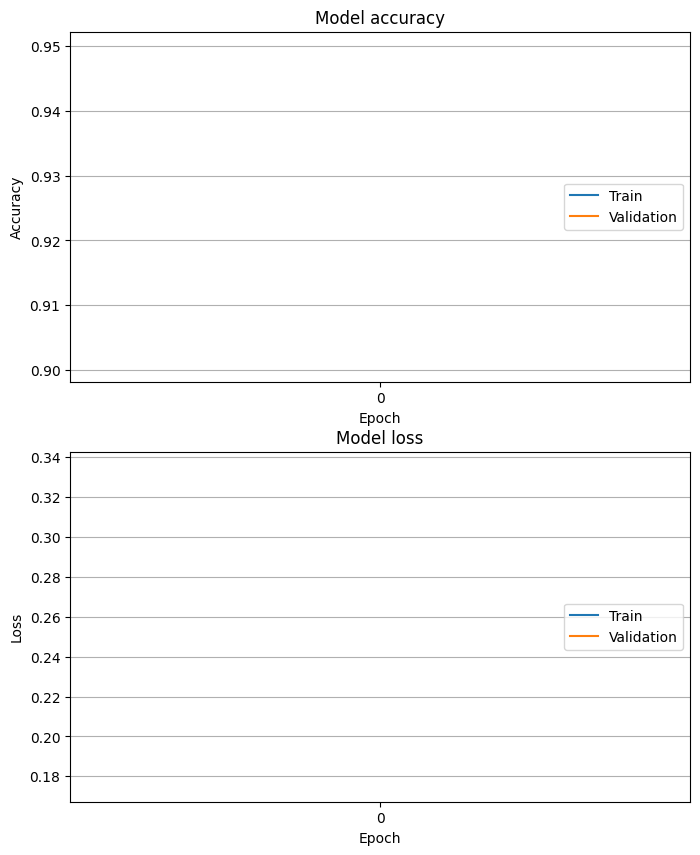

In [9]:
history = pickle.load(open("Model/history/train_history_dict", "rb"))
plot_history(history)

### 9. Save Parameters and Weights on Header Files

In [10]:
save_param_on_files(model)

writing 'definitions.h' file... done.
writing 'conv_weights.h' file... done.
writing 'dense_weights.h' file... done.
